# Visualizing Predictions

## Import dependencies

In [1]:
import os

import numpy as np
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

from dataset import BraTS2020Dataset as Dataset
from simple_3d_unet import Simple3DUNET
from utils import plot_metrics, load_checkpoint, calc_dice_score, calc_accuracy

## Configuration and Setup (Hyperparameters etc...)

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 1
NUM_EPOCHS = 100
NUM_WORKERS = os.cpu_count()
PIN_MEMORY = True
CLASS_WEIGHTS = torch.tensor([1, 1, 1, 1])
VAL_IMG_DIR = "../data/input_data_split/val/images"
VAL_MASK_DIR = "../data/input_data_split/val/masks"

## Dataset and DataLoader Setup

In [3]:
val_dataset = Dataset(image_dir=VAL_IMG_DIR, mask_dir=VAL_MASK_DIR)

In [4]:
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY,
                            shuffle=False)

## Model Initialization and Loading Checkpoint

In [5]:
model = Simple3DUNET(in_channels=3, out_channels=4).to(DEVICE)
load_checkpoint("../checkpoints/best_model_100.pth", model)

=> Loading checkpoint


## Plot Training Metrics

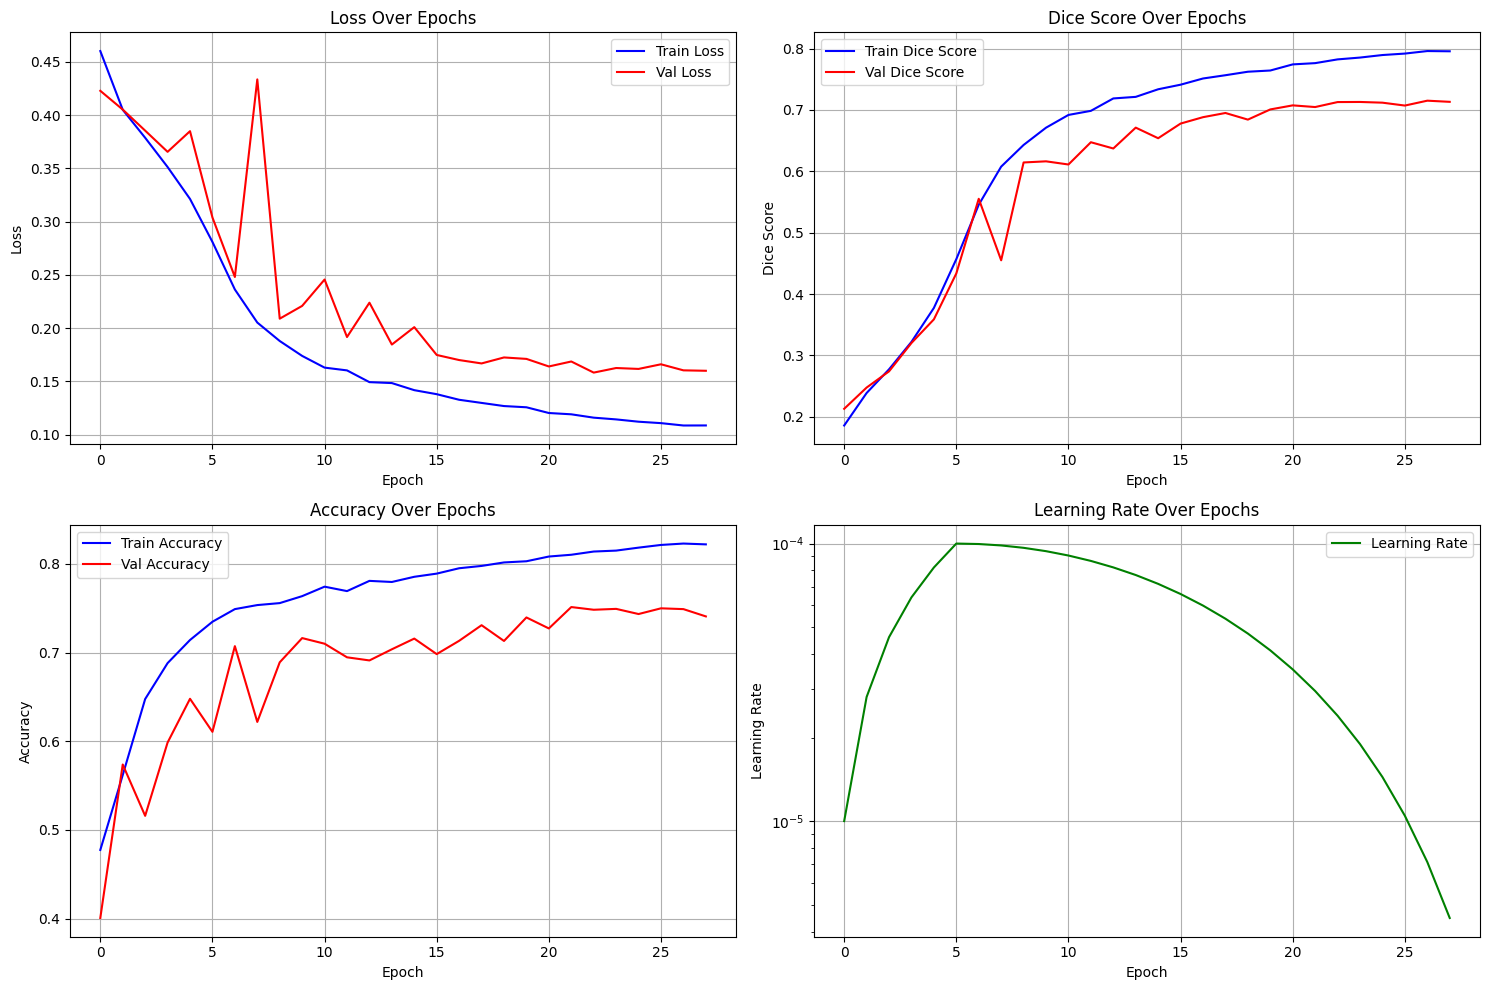

In [6]:
import json

with open("../results/history.json") as f:
    history = json.load(f)

plot_metrics(history)

## Model Evaluation on Validation Set

In [7]:
model.eval()
total_dice, total_acc = 0.0, 0.0
with torch.inference_mode():
    for batch, (X, y) in enumerate(pbar := tqdm(val_dataloader, desc='Validating', colour="green")):
        X, y = X.to(DEVICE), y.to(DEVICE)
        y_pred = model(X)

        # Metrics computation
        total_dice += calc_dice_score(y_pred, y, CLASS_WEIGHTS)
        total_acc += calc_accuracy(y_pred, y, CLASS_WEIGHTS)

        # Update pbar
        pbar.set_postfix(dice=total_dice / (batch + 1), acc=total_acc / (batch + 1))

avg_dice = total_dice / len(val_dataloader)
avg_acc = total_acc / len(val_dataloader)
print(f"Average Dice score: {avg_dice} | Average Accuracy: {avg_acc}")

Validating: 100%|██████████| 86/86 [00:15<00:00,  5.67it/s, acc=0.748, dice=0.713]

Average Dice score: 0.7128011570420376 | Average Accuracy: 0.7482232357873473


## Inference on a Single Test Image

In [8]:
img_num = 82

test_img = np.load(f"../data/input_data_split/val/images/image_{img_num}.npy")

test_mask = np.load(f"../data/input_data_split/val/masks/mask_{img_num}.npy")
test_mask_argmax = np.argmax(test_mask, axis=3)

test_prediction = model(torch.from_numpy(test_img).type(torch.float32).permute(3, 0, 1, 2).unsqueeze(0).to(DEVICE))
test_prediction_argmax = np.argmax(test_prediction.permute(0, 2, 3, 4, 1).detach().cpu().numpy(), axis=4)[0, :, :, :]

## Visualization of Test Image and Prediction

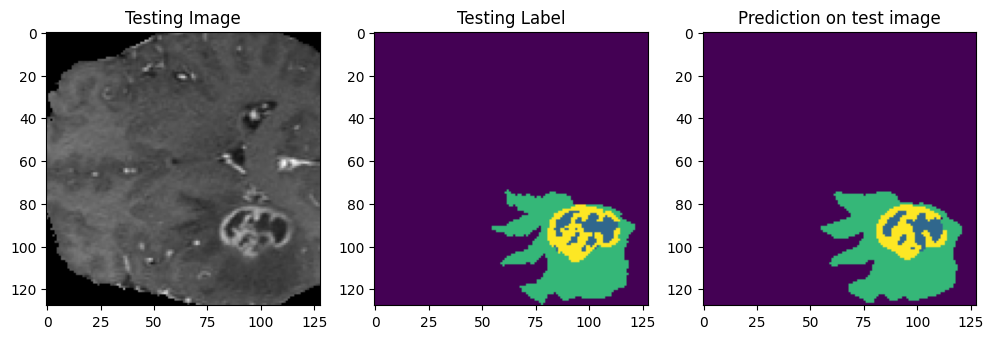

In [9]:
from matplotlib import pyplot as plt

#n_slice=random.randint(0, test_prediction_argmax.shape[2])
n_slice = 55
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:, :, n_slice, 1], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_argmax[:, :, n_slice])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction_argmax[:, :, n_slice])
plt.show()